In [1]:
import pandas as pd
import os

# Load CSV metadata
meta_df = pd.read_csv('ESC-50-master/meta/esc50.csv')

# Add full path to audio files
meta_df['filepath'] = meta_df['filename'].apply(lambda x: os.path.join('ESC-50-master/audio/', x))

# Display sample
meta_df.head()


,filename,fold,target,category,esc10,src_file,take,filepath
0,1-100032-A-0.wav,1,0,dog,True,100032,A,ESC-50-master/audio/1-100032-A-0.wav
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,ESC-50-master/audio/1-100038-A-14.wav
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,ESC-50-master/audio/1-100210-A-36.wav
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,ESC-50-master/audio/1-100210-B-36.wav
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,ESC-50-master/audio/1-101296-A-19.wav


In [2]:
import random
import librosa
import numpy as np
import torch
from torch.utils.data import Dataset
from audiomentations import Compose, AddGaussianNoise, PitchShift, TimeStretch, Gain

class ESC50Dataset(Dataset):
    def __init__(self, df, sample_rate=44100, duration=5.0, augment_type='none', n_mels=128):
        self.df = df.reset_index(drop=True)
        self.sr = sample_rate
        self.length = int(sample_rate * duration)
        self.augment_type = augment_type
        self.n_mels = n_mels

        self.weak_transform = Compose([
            AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
        ])
        self.strong_transform = Compose([
            AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.02, p=0.5),
            PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
            TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
            Gain(min_gain_db=-6, max_gain_db=6, p=0.5)
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row['filepath']
        label = row['target'] if 'target' in row else -1

        y, _ = librosa.load(path, sr=self.sr)
        if len(y) < self.length:
            y = np.pad(y, (0, self.length - len(y)))
        else:
            y = y[:self.length]

        if self.augment_type == 'weak':
            y = self.weak_transform(samples=y, sample_rate=self.sr)
        elif self.augment_type == 'strong':
            y = self.strong_transform(samples=y, sample_rate=self.sr)

        # Convert to Mel spectrogram
        mel = librosa.feature.melspectrogram(y=y, sr=self.sr, n_mels=self.n_mels)
        mel_db = librosa.power_to_db(mel + 1e-6, ref=np.max)
        mel_db = np.clip(mel_db, a_min=-80, a_max=0)  # Avoid crazy ranges


        # Normalize and convert to torch tensor [1, H, W]
        mel_tensor = torch.tensor(mel_db, dtype=torch.float32).unsqueeze(0)

        return mel_tensor, torch.tensor(label, dtype=torch.long)


In [3]:
def split_ssl_with_ood(id_df, ood_df, labeled_fraction=0.2, ood_fraction=0.3, save_dir="osp-split"):
    import os
    os.makedirs(save_dir, exist_ok=True)

    labeled_df_list = []
    unlabeled_combined_list = []

    # Process ID classes
    for label in sorted(id_df['target'].unique()):
        class_df = id_df[id_df['target'] == label]
        n_labeled = max(1, int(len(class_df) * labeled_fraction))

        # Labeled samples
        labeled_samples = class_df.sample(n=n_labeled, random_state=42)
        labeled_df_list.append(labeled_samples)

        # Remaining go to unlabeled (with is_ood = 0), drop target/category
        unlabeled_samples = class_df.drop(labeled_samples.index).copy()
        unlabeled_samples["is_ood"] = 0
        unlabeled_samples = unlabeled_samples.drop(columns=["target", "category"])
        unlabeled_combined_list.append(unlabeled_samples)

    # Combine labeled ID samples
    labeled_df = pd.concat(labeled_df_list).reset_index(drop=True)

    # Combine ID-unlabeled samples first
    id_unlabeled_df = pd.concat(unlabeled_combined_list).reset_index(drop=True)
    
    # n_ood = γ / (1 - γ) * ID-unlabeled
    n_id_unlabeled = len(id_unlabeled_df)
    n_ood = int(ood_fraction * n_id_unlabeled / (1 - ood_fraction))
    
    # Safe sampling: don't go beyond available OOD data
    n_ood = min(n_ood, len(ood_df))
    
    # Sample OOD data
    unlabeled_ood_df = ood_df.sample(n=n_ood, random_state=42).copy().reset_index(drop=True)
    unlabeled_ood_df["is_ood"] = 1
    unlabeled_ood_df = unlabeled_ood_df.drop(columns=["target", "category"])
    
    # Combine and save
    unlabeled_df = pd.concat([id_unlabeled_df, unlabeled_ood_df], ignore_index=True)

    # Save files
    labeled_df.to_csv(f"{save_dir}/labeled{ood_fraction}.csv", index=False)
    unlabeled_df.to_csv(f"{save_dir}/unlabeled{ood_fraction}.csv", index=False)

    print(f"Saved {len(labeled_df)} labeled samples and {len(unlabeled_df)} unlabeled samples to '{save_dir}'")


In [4]:
from torch.utils.data import DataLoader

def get_ssl_loaders(meta_df,labeled_fraction=0.1, fold=1, batch_size=16, split_dir="labeled-unlabeled"):
    # Load pre-saved labeled and unlabeled CSVs for this fold
    labeled_df = pd.read_csv(f"{split_dir}/{labeled_fraction}/labeled.csv")
    unlabeled_df = pd.read_csv(f"{split_dir}/{labeled_fraction}/unlabeled.csv")

    # Get validation set from meta_df
    val_df = meta_df[meta_df['fold'] == fold]

    # Create datasets
    labeled_dataset = ESC50Dataset(labeled_df, augment_type='weak')
    unlabeled_dataset = DualViewESC50Dataset(unlabeled_df)
    val_dataset = ESC50Dataset(val_df, augment_type='none')

    # Create loaders
    labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    return labeled_loader, unlabeled_loader, val_loader



In [5]:
class DualViewESC50Dataset(Dataset):
    def __init__(self, df):
        self.weak_dataset = ESC50Dataset(df, augment_type='weak')
        self.strong_dataset = ESC50Dataset(df, augment_type='strong')

    def __len__(self):
        return len(self.weak_dataset)

    def __getitem__(self, idx):
        weak_x, _ = self.weak_dataset[idx]
        strong_x, _ = self.strong_dataset[idx]
        return weak_x, strong_x


In [6]:
import random

# Set random seed for reproducibility
random.seed(42)

# All 50 class indices
all_class_ids = list(range(50))

# Randomly choose ID and OOD classes
num_id_classes = 40
id_class_ids = sorted(random.sample(all_class_ids, num_id_classes))
label_map = {orig_class: new_idx for new_idx, orig_class in enumerate(sorted(id_class_ids))}
print(label_map)

ood_class_ids = sorted(list(set(all_class_ids) - set(id_class_ids)))

print(f"ID Classes: {id_class_ids}")
print(f"OOD Classes: {ood_class_ids}")


{0: 0, 1: 1, 2: 2, 3: 3, 5: 4, 6: 5, 7: 6, 8: 7, 10: 8, 12: 9, 13: 10, 14: 11, 15: 12, 17: 13, 18: 14, 20: 15, 21: 16, 22: 17, 24: 18, 27: 19, 28: 20, 30: 21, 31: 22, 32: 23, 33: 24, 34: 25, 35: 26, 36: 27, 37: 28, 38: 29, 39: 30, 40: 31, 41: 32, 42: 33, 43: 34, 44: 35, 46: 36, 47: 37, 48: 38, 49: 39}
ID Classes: [0, 1, 2, 3, 5, 6, 7, 8, 10, 12, 13, 14, 15, 17, 18, 20, 21, 22, 24, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49]
OOD Classes: [4, 9, 11, 16, 19, 23, 25, 26, 29, 45]


In [7]:
id_df = meta_df[meta_df['target'].isin(id_class_ids)].copy()
ood_df = meta_df[meta_df['target'].isin(ood_class_ids)].copy()

print(len(id_df))
print(id_df.head())
print(len(ood_df))
print(ood_df.head())

1600
            filename  fold  target         category  esc10  src_file take  \
0   1-100032-A-0.wav     1       0              dog   True    100032    A   
1  1-100038-A-14.wav     1      14   chirping_birds  False    100038    A   
2  1-100210-A-36.wav     1      36   vacuum_cleaner  False    100210    A   
3  1-100210-B-36.wav     1      36   vacuum_cleaner  False    100210    B   
6  1-101336-A-30.wav     1      30  door_wood_knock  False    101336    A   

                                filepath  
0   ESC-50-master/audio/1-100032-A-0.wav  
1  ESC-50-master/audio/1-100038-A-14.wav  
2  ESC-50-master/audio/1-100210-A-36.wav  
3  ESC-50-master/audio/1-100210-B-36.wav  
6  ESC-50-master/audio/1-101336-A-30.wav  
400
             filename  fold  target      category  esc10  src_file take  \
4   1-101296-A-19.wav     1      19  thunderstorm  False    101296    A   
5   1-101296-B-19.wav     1      19  thunderstorm  False    101296    B   
8    1-103298-A-9.wav     1       9          

In [24]:
split_ssl_with_ood(
    id_df=id_df,
    ood_df=ood_df,
    labeled_fraction=0.2,   
    ood_fraction=0.3,       # this is γ in the OSP paper
    save_dir="osp-split/0.2"
)


Saved 320 labeled samples and 1680 unlabeled samples to 'osp-split/0.2'


In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

class OSPModel(nn.Module):
    def __init__(self, num_classes=40, backbone='resnet18'):
        super(OSPModel, self).__init__()
        self.encoder = self._build_encoder(backbone)

        with torch.no_grad():
            dummy = torch.randn(1, 1, 128, 431)
            feature_size = self.encoder(dummy).shape[1]

        self.classifier_head = nn.Linear(feature_size, num_classes)
        self.ssp_head = nn.Linear(feature_size, 4)  # 4 audio transforms

    def _build_encoder(self, backbone):
        model = models.resnet18(pretrained=True)
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        model.fc = nn.Identity()
        return model

    def forward(self, x, task='class'):
        features = self.encoder(x)
        features = features.view(features.size(0), -1)

        if task == 'class':
            return self.classifier_head(features)
        elif task == 'ssp':
            return self.ssp_head(features)
        elif task == 'feature':
            return features
        else:
            raise ValueError(f"Unknown task '{task}'")




In [9]:
from audiomentations import Compose, TimeStretch, PitchShift, Gain

class AudioTransformDataset(Dataset):
    def __init__(self, df, sample_rate=44100, duration=5.0, n_mels=128):
        self.df = df.reset_index(drop=True)
        self.sr = sample_rate
        self.length = int(sample_rate * duration)
        self.n_mels = n_mels

        self.transforms = [
            lambda x: x,  # No transform → class 0
            TimeStretch(min_rate=0.8, max_rate=0.8, p=1.0),  # class 1
            PitchShift(min_semitones=4, max_semitones=4, p=1.0),  # class 2
            Gain(min_gain_db=6, max_gain_db=6, p=1.0),  # class 3
        ]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row['filepath']

        y, _ = librosa.load(path, sr=self.sr)
        if len(y) < self.length:
            y = np.pad(y, (0, self.length - len(y)))
        else:
            y = y[:self.length]

        # Apply random transformation
        label = random.randint(0, 3)
        y_aug = self.transforms[label](samples=y, sample_rate=self.sr) if label != 0 else y

        mel = librosa.feature.melspectrogram(y=y_aug, sr=self.sr, n_mels=self.n_mels)
        mel_db = librosa.power_to_db(mel + 1e-6, ref=np.max)
        mel_db = np.clip(mel_db, a_min=-80, a_max=0)
        mel_tensor = torch.tensor(mel_db, dtype=torch.float32).unsqueeze(0)

        return mel_tensor, torch.tensor(label)


In [10]:
unlabeled_df = pd.read_csv("osp-split/0.2/unlabeled0.3.csv")
ssp_dataset = AudioTransformDataset(unlabeled_df)
ssp_loader = DataLoader(ssp_dataset, batch_size=32, shuffle=True)


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

model = OSPModel(num_classes=num_id_classes)

# Losses
criterion_cls = nn.CrossEntropyLoss()
criterion_rot = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)

def train_osp(model, labeled_loader, ssp_loader, num_epochs=50, device='cuda', save_path="osp_pretrained.pt"):
    model.to(device)

    # Track current epoch if resuming
    start_epoch = 0

    # Load pretrained checkpoint if it exists
    if os.path.exists(save_path):
        print(f"Loading checkpoint from: {save_path}")
        checkpoint = torch.load(save_path, map_location=device)
        model.load_state_dict(checkpoint['model_state'])
        start_epoch = checkpoint.get('epoch', 0)
        print(f"Resuming training from epoch {start_epoch + 1}")
    else:
        print("Starting pretraining from scratch...")

    model.train()
    criterion_cls = nn.CrossEntropyLoss()
    criterion_ssp = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

    for epoch in range(start_epoch, num_epochs):
        total_cls_loss = 0.0
        total_ssp_loss = 0.0
        correct_cls = 0
        total_cls = 0
        correct_ssp = 0
        total_ssp = 0

        # Supervised classification
        for x, y in labeled_loader:
            x, y = x.to(device), y.to(device)

            pred = model(x, task='class')
            loss_cls = criterion_cls(pred, y)

            optimizer.zero_grad()
            loss_cls.backward()
            optimizer.step()

            total_cls_loss += loss_cls.item()
            preds_cls = pred.argmax(dim=1)
            correct_cls += (preds_cls == y).sum().item()
            total_cls += y.size(0)

        # Self-supervised transform prediction
        for x_aug, ssp_label in ssp_loader:
            x_aug, ssp_label = x_aug.to(device), ssp_label.to(device)

            pred_ssp = model(x_aug, task='ssp')
            loss_ssp = criterion_ssp(pred_ssp, ssp_label)

            optimizer.zero_grad()
            loss_ssp.backward()
            optimizer.step()

            total_ssp_loss += loss_ssp.item()
            preds_ssp = pred_ssp.argmax(dim=1)
            correct_ssp += (preds_ssp == ssp_label).sum().item()
            total_ssp += ssp_label.size(0)

        cls_acc = 100 * correct_cls / total_cls if total_cls else 0
        ssp_acc = 100 * correct_ssp / total_ssp if total_ssp else 0

        print(f"[Epoch {epoch+1}] "
              f"Cls Loss: {total_cls_loss:.4f} | Cls Acc: {cls_acc:.2f}% || "
              f"SSP Loss: {total_ssp_loss:.4f} | SSP Acc: {ssp_acc:.2f}%")

        # Save checkpoint after every epoch
        torch.save({
            'epoch': epoch + 1,
            'model_state': model.state_dict(),
        }, save_path)
        print(f"Checkpoint saved to {save_path}")

    return model



C:\Users\Arnav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Arnav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
os.makedirs("models/ESC-50/OSP", exist_ok=True)

labeled_df = pd.read_csv("osp-split/0.2/labeled0.3.csv")
labeled_df['target'] = labeled_df['target'].map(label_map)

unlabeled_df = pd.read_csv("osp-split/0.2/unlabeled0.3.csv")

# Create datasets
labeled_dataset = ESC50Dataset(labeled_df, augment_type='weak')
ssp_dataset = AudioTransformDataset(unlabeled_df)  # for SSP pretraining

labeled_loader = DataLoader(labeled_dataset, batch_size=16, shuffle=True)
ssp_loader = DataLoader(ssp_dataset, batch_size=32, shuffle=True)

trained_model = train_osp(
    model=model,
    labeled_loader=labeled_loader,
    ssp_loader=ssp_loader,
    num_epochs=15,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    save_path="models/ESC-50/OSP/osp_pretrained.pt"
)


Loading checkpoint from: models/ESC-50/OSP/osp_pretrained.pt
Resuming training from epoch 13
[Epoch 13] Cls Loss: 6.5420 | Cls Acc: 90.62% || SSP Loss: 34.3659 | SSP Acc: 66.13%
Checkpoint saved to models/ESC-50/OSP/osp_pretrained.pt
[Epoch 14] Cls Loss: 6.0413 | Cls Acc: 94.06% || SSP Loss: 33.9267 | SSP Acc: 66.01%
Checkpoint saved to models/ESC-50/OSP/osp_pretrained.pt


KeyboardInterrupt: 

In [12]:
print(len(label_map))
model = OSPModel(num_classes=len(label_map))
checkpoint = torch.load("models/ESC-50/OSP/osp_pretrained.pt", map_location='cpu')
model.load_state_dict(checkpoint['model_state'])
model.eval()
print("Pretrained Model loaded.")
model.to('cuda' if torch.cuda.is_available() else 'cpu')


40
Pretrained Model loaded.


OSPModel(
  (encoder): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [13]:
class FeatureExtractorDataset(Dataset):
    def __init__(self, df, device='cpu'):
        self.df = df.reset_index(drop=True)
        self.device = device
        self.dataset = ESC50Dataset(df, augment_type='none')

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x, _ = self.dataset[idx]
        is_ood = self.df.iloc[idx].get("is_ood", -1)
        return x.to(self.device), is_ood


In [14]:
from torch.utils.data import DataLoader

unlabeled_df = pd.read_csv("osp-split/0.2/unlabeled0.3.csv")
feature_dataset = FeatureExtractorDataset(unlabeled_df, device='cuda' if torch.cuda.is_available() else 'cpu')
feature_loader = DataLoader(feature_dataset, batch_size=32)

features = []
is_ood_flags = []

with torch.no_grad():
    for x, flag in feature_loader:
        feats = model(x, task='feature')
        features.append(feats.cpu())
        is_ood_flags.append(flag.cpu())

features = torch.cat(features)  # shape: [N, D]
is_ood_flags = torch.cat(is_ood_flags)  # shape: [N]


In [15]:
feature_scores = features.norm(dim=1)  # [N] — L2 norm of each feature


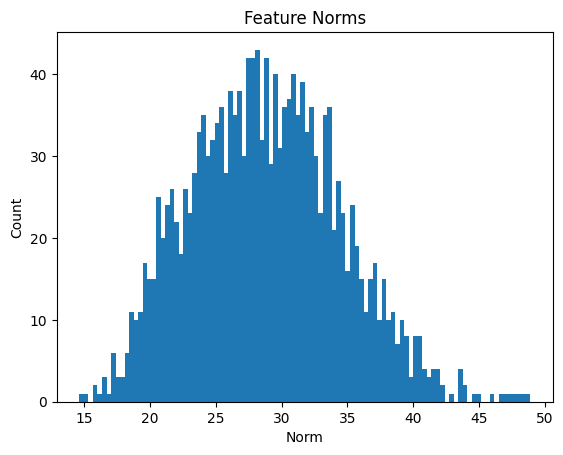

In [16]:
import matplotlib.pyplot as plt

plt.hist(feature_scores.numpy(), bins=100)
plt.title("Feature Norms")
plt.xlabel("Norm")
plt.ylabel("Count")
plt.show()


In [17]:
from skimage.filters import threshold_otsu

threshold = threshold_otsu(feature_scores.numpy())
print(f"Otsu Threshold: {threshold:.4f}")


Otsu Threshold: 29.0321


In [18]:
id_mask = feature_scores >= threshold  # confident ID
ood_mask = feature_scores < threshold  # predicted OOD

# sanity check
print(f"Predicted ID: {id_mask.sum().item()} / {len(id_mask)}")
print(f"Predicted OOD: {ood_mask.sum().item()} / {len(ood_mask)}")


Predicted ID: 793 / 1680
Predicted OOD: 887 / 1680


In [19]:
from sklearn.metrics import roc_auc_score

auroc = roc_auc_score(is_ood_flags.numpy(), -feature_scores.numpy())  # lower norm → more likely OOD
print(f"AUROC for OOD detection: {auroc:.4f}")


AUROC for OOD detection: 0.4453


In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


with torch.no_grad():
    logits = []
    for x in feature_loader:
        x = x[0].to(device)  # if flag removed
        logit = model(x, task='class')
        logits.append(logit.cpu())

logits = torch.cat(logits)
probs = torch.softmax(logits, dim=1)
entropy = -torch.sum(probs * torch.log(probs + 1e-8), dim=1)  # shape: [N]


In [33]:
from skimage.filters import threshold_otsu
threshold = threshold_otsu(entropy.numpy())

id_mask = entropy <= threshold
ood_mask = entropy > threshold

print(f"Predicted ID: {id_mask.sum().item()} / {len(id_mask)}")
print(f"Predicted OOD: {ood_mask.sum().item()} / {len(ood_mask)}")

from sklearn.metrics import roc_auc_score
auroc = roc_auc_score(is_ood_flags.numpy(), entropy.numpy())
print(f"AUROC (entropy): {auroc:.4f}")


Predicted ID: 677 / 1680
Predicted OOD: 1003 / 1680
AUROC (entropy): 0.5356


In [28]:
import torch
import torch.nn.functional as F
import random

# === 1. Build centroids from labeled data ===
def compute_class_centroids(model, labeled_loader, device):
    model.eval()
    class_features = {}
    with torch.no_grad():
        for x, y in labeled_loader:
            x, y = x.to(device), y.to(device)
            feats = model(x, task='feature')
            for f, label in zip(feats, y):
                label = label.item()
                if label not in class_features:
                    class_features[label] = []
                class_features[label].append(f.cpu())
    centroids = {c: torch.stack(v).mean(dim=0) for c, v in class_features.items()}
    return centroids


# === 2. Build OOD memory bank ===
def build_ood_memory_bank(centroids, ood_features):
    memory_bank = {c: [] for c in centroids}
    for f_ood in ood_features:
        best_c = max(centroids, key=lambda c: F.cosine_similarity(
            f_ood.unsqueeze(0), centroids[c].unsqueeze(0)).item())
        memory_bank[best_c].append(f_ood)
    return memory_bank


# === 3. Apply semantic orthogonal removal ===
def apply_sor(f, f_ood, alpha=1.0):
    proj = (f @ f_ood) / (f_ood.norm()**2 + 1e-8) * f_ood
    return f - alpha * proj

def apply_aom(f, f_ood_list, alpha=1.0, top_k=3):
    # Compute cosine similarities
    sims = [F.cosine_similarity(f.unsqueeze(0), v.unsqueeze(0), dim=-1).item() for v in f_ood_list]
    top_indices = sorted(range(len(sims)), key=lambda i: sims[i], reverse=True)[:top_k]

    total_proj = torch.zeros_like(f)
    for i in top_indices:
        v = f_ood_list[i]
        proj = (f @ v) / (v.norm()**2 + 1e-8) * v
        total_proj += proj

    return f - alpha * total_proj


# === 4. ODC loss (labeled only or unlabeled too) ===
def odc_loss(model, feats, labels, memory_bank, alpha=1.0, method='sor', top_k=3):
    loss = 0.0
    for i in range(feats.size(0)):
        c = labels[i].item()
        if memory_bank[c]:
            f = feats[i]
            f_ood_list = [v.to(feats.device) for v in memory_bank[c]]

            if method == 'sor':
                f_pruned = apply_sor(f, random.choice(f_ood_list), alpha)
            elif method == 'aom':
                f_pruned = apply_aom(f, f_ood_list, alpha=alpha, top_k=top_k)
            else:
                raise ValueError(f"Unknown pruning method: {method}")

            p1 = F.softmax(model.classifier_head(f), dim=-1)
            p2 = F.softmax(model.classifier_head(f_pruned), dim=-1)
            loss += F.mse_loss(p1, p2, reduction='sum')
    return loss / feats.size(0)




In [29]:
def train_with_odc(
    model,
    labeled_df,
    memory_bank,
    batch_size=32,
    alpha=1.0,
    lambda_odc=0.5,
    num_epochs=10,
    device='cuda',
    method='sor',           # 'sor' or 'aom'
    top_k=3                 # only for AOM
):
    from torch.utils.data import DataLoader
    import os

    # === Preprocess labeled dataset ===
    train_dataset = ESC50Dataset(labeled_df, augment_type='weak')
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # === Optimizer and loss ===
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    criterion = torch.nn.CrossEntropyLoss()
    model.to(device)

    # === Determine save path ===
    save_dir = "models/ESC-50/OSP"
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"pretrained_{method}.pt")

    print(f"Starting fine-tuning with ODC ({method.upper()})...")
    for epoch in range(num_epochs):
        model.train()
        total_loss, total_cls, total_odc = 0, 0, 0
        correct, total = 0, 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            # === Forward pass ===
            feats = model(x, task='feature')
            logits = model.classifier_head(feats)

            # === Losses ===
            loss_cls = criterion(logits, y)
            loss_odc = odc_loss(model, feats, y, memory_bank, alpha=alpha, method=method, top_k=top_k)
            loss = loss_cls + lambda_odc * loss_odc

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # === Logging ===
            total_loss += loss.item()
            total_cls += loss_cls.item()
            total_odc += loss_odc.item()
            correct += (logits.argmax(dim=1) == y).sum().item()
            total += y.size(0)

        acc = 100 * correct / total
        print(f"[Epoch {epoch+1}] Total Loss: {total_loss:.3f} | "
              f"Cls Loss: {total_cls:.3f} | ODC Loss: {total_odc:.3f} | Acc: {acc:.2f}%")

    # === Save model ===
    torch.save(model.state_dict(), save_path)
    print(f"Fine-tuned model saved to: {save_path}")


In [20]:
!pip install scikit-image

   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   ------------------ --------------------- 5.8/12.8 MB 25.1 MB/s eta 0:00:01
   ------------------------------------ --- 11.5/12.8 MB 27.7 MB/s eta 0:00:01
   ---------------------------------------- 12.8/12.8 MB 25.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 26.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/41.2 MB ? eta -:--:--
   ------- -------------------------------- 7.6/41.2 MB 36.2 MB/s eta 0:00:01
   -------------- ------------------------- 14.7/41.2 MB 34.2 MB/s eta 0:00:01
   -------------------- ------------------- 21.5/41.2 MB 34.0 MB/s eta 0:00:01
   -------------------------- ------------- 27.5/41.2 MB 32.3 MB/s eta 0:00:01
   --------------------------------- ------ 34.1/41.2 MB 32.8 MB/s eta 0:00:01
   ---------------------------------------  40.6/41.2 MB 32.7 MB/s eta 0:00:01
   --

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: C:\Users\Arnav\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OSPModel(num_classes=len(label_map))
checkpoint = torch.load("models/ESC-50/OSP/osp_pretrained.pt", map_location='cpu')
model.load_state_dict(checkpoint['model_state'])
model.to('cuda' if torch.cuda.is_available() else 'cpu')

labeled_df = pd.read_csv("osp-split/0.2/labeled0.3.csv")
labeled_df['target'] = labeled_df['target'].map(label_map)
labeled_dataset = ESC50Dataset(labeled_df, augment_type='weak')
labeled_loader = DataLoader(labeled_dataset, batch_size=16, shuffle=True)

ood_features = features[ood_mask] 

centroids = compute_class_centroids(model, labeled_loader, device)

memory_bank = build_ood_memory_bank(centroids, ood_features)

train_with_odc(
    model=model,  # pretrained and loaded
    labeled_df=labeled_df,
    memory_bank=memory_bank,
    method='aom',      
    top_k=3,
    alpha=1.0,
    lambda_odc=0.5,
    num_epochs=10,
    batch_size=32,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)


C:\Users\Arnav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Arnav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting fine-tuning with ODC (AOM)...
[Epoch 1] Total Loss: 6.531 | Cls Loss: 2.113 | ODC Loss: 8.837 | Acc: 95.94%
[Epoch 2] Total Loss: 5.521 | Cls Loss: 1.646 | ODC Loss: 7.751 | Acc: 96.25%
[Epoch 3] Total Loss: 4.615 | Cls Loss: 0.911 | ODC Loss: 7.409 | Acc: 97.50%
[Epoch 4] Total Loss: 4.044 | Cls Loss: 0.507 | ODC Loss: 7.075 | Acc: 99.38%
[Epoch 5] Total Loss: 4.081 | Cls Loss: 0.682 | ODC Loss: 6.798 | Acc: 99.06%
[Epoch 6] Total Loss: 3.638 | Cls Loss: 0.454 | ODC Loss: 6.369 | Acc: 99.38%
[Epoch 7] Total Loss: 3.726 | Cls Loss: 0.706 | ODC Loss: 6.041 | Acc: 98.44%
[Epoch 8] Total Loss: 3.957 | Cls Loss: 1.000 | ODC Loss: 5.916 | Acc: 98.75%
[Epoch 9] Total Loss: 3.380 | Cls Loss: 0.418 | ODC Loss: 5.923 | Acc: 99.06%
[Epoch 10] Total Loss: 3.186 | Cls Loss: 0.323 | ODC Loss: 5.726 | Acc: 99.69%
Fine-tuned model saved to: models/ESC-50/OSP\pretrained_aom.pt


In [31]:
# Reload the pretrained model from scratch
model = OSPModel(num_classes=len(label_map))
checkpoint = torch.load("models/ESC-50/OSP/osp_pretrained.pt", map_location='cpu')
model.load_state_dict(checkpoint['model_state'])
model.to(device)

# call train_with_odc with method='sor'
train_with_odc(
    model=model,
    labeled_df=labeled_df,
    memory_bank=memory_bank,
    method='sor',
    alpha=1.0,
    lambda_odc=0.5,
    num_epochs=10,
    batch_size=32,
    device=device
)


C:\Users\Arnav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Arnav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting fine-tuning with ODC (SOR)...
[Epoch 1] Total Loss: 1.877 | Cls Loss: 1.249 | ODC Loss: 1.257 | Acc: 98.12%
[Epoch 2] Total Loss: 0.820 | Cls Loss: 0.485 | ODC Loss: 0.672 | Acc: 99.38%
[Epoch 3] Total Loss: 0.914 | Cls Loss: 0.707 | ODC Loss: 0.414 | Acc: 98.44%
[Epoch 4] Total Loss: 0.493 | Cls Loss: 0.348 | ODC Loss: 0.291 | Acc: 99.38%
[Epoch 5] Total Loss: 0.245 | Cls Loss: 0.144 | ODC Loss: 0.202 | Acc: 100.00%
[Epoch 6] Total Loss: 0.381 | Cls Loss: 0.295 | ODC Loss: 0.171 | Acc: 99.69%
[Epoch 7] Total Loss: 0.314 | Cls Loss: 0.254 | ODC Loss: 0.120 | Acc: 99.69%
[Epoch 8] Total Loss: 0.206 | Cls Loss: 0.133 | ODC Loss: 0.145 | Acc: 99.69%
[Epoch 9] Total Loss: 0.155 | Cls Loss: 0.078 | ODC Loss: 0.155 | Acc: 100.00%
[Epoch 10] Total Loss: 0.101 | Cls Loss: 0.052 | ODC Loss: 0.098 | Acc: 100.00%
Fine-tuned model saved to: models/ESC-50/OSP\pretrained_sor.pt


In [32]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

def evaluate_model_foldwise(model_path, meta_df, label_map, id_class_ids, batch_size=32, device='cuda'):
    print(f"\nEvaluating model: {model_path}")
    num_classes = len(label_map)

    all_fold_metrics = []

    for fold in range(1, 6):  # ESC-50 has folds 1 to 5
        print(f"\n=== Fold {fold} ===")
        model = OSPModel(num_classes=num_classes)
        checkpoint = torch.load(model_path, map_location='cpu')
        model.load_state_dict(checkpoint)
        model.to(device)
        model.eval()

        # Prepare validation set (only ID classes)
        val_df = meta_df[(meta_df['fold'] == fold) & (meta_df['target'].isin(id_class_ids))].copy()
        val_df['target'] = val_df['target'].map(label_map)
        val_dataset = ESC50Dataset(val_df, augment_type='none')
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        y_true, y_pred, y_probs = [], [], []

        with torch.no_grad():
            for x, y in tqdm(val_loader):
                x, y = x.to(device), y.to(device)
                logits = model(x, task='class')
                preds = torch.argmax(logits, dim=1)
                probs = torch.softmax(logits, dim=1)

                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                y_probs.extend(probs.cpu().numpy())

        # Metrics
        acc = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

        try:
            auc_roc = roc_auc_score(
                y_true, y_probs, multi_class='ovr', average='macro'
            )
        except:
            auc_roc = None

        try:
            auc_prc = average_precision_score(
                y_true, y_probs, average='macro'
            )
        except:
            auc_prc = None

        print(f"Accuracy: {acc:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"AUC-PRC: {auc_prc if auc_prc else 'N/A'}")
        print(f"AUC-ROC: {auc_roc if auc_roc else 'N/A'}")

        all_fold_metrics.append({
            'Fold': fold,
            'Accuracy': acc,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'AUC-PRC': auc_prc,
            'AUC-ROC': auc_roc
        })

    # Summary
    print("\n=== Summary (Mean across 5 folds) ===")
    df = pd.DataFrame(all_fold_metrics)
    print(df.mean(numeric_only=True))

    return df


In [35]:
# Evaluate AOM-finetuned model
df_results_aom = evaluate_model_foldwise(
    model_path="models/ESC-50/OSP/pretrained_aom.pt",
    meta_df=meta_df,
    label_map=label_map,
    id_class_ids=id_class_ids,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)




Evaluating model: models/ESC-50/OSP/pretrained_aom.pt

=== Fold 1 ===


C:\Users\Arnav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Arnav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.26it/s]
C:\Users\Arnav\AppData\Local\Packages\PythonSoftwareFoundat

Accuracy: 0.7344
Precision: 0.7774
Recall: 0.7344
F1 Score: 0.7218
AUC-PRC: 0.8390696293486579
AUC-ROC: 0.9848557692307693

=== Fold 2 ===


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.19it/s]
C:\Users\Arnav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Arnav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy: 0.7281
Precision: 0.7880
Recall: 0.7281
F1 Score: 0.7279
AUC-PRC: 0.8438539245124386
AUC-ROC: 0.9751302083333334

=== Fold 3 ===


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.19it/s]
C:\Users\Arnav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Arnav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy: 0.7844
Precision: 0.8246
Recall: 0.7844
F1 Score: 0.7817
AUC-PRC: 0.8914925922126921
AUC-ROC: 0.9863581730769232

=== Fold 4 ===


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.24it/s]
C:\Users\Arnav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Arnav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy: 0.7531
Precision: 0.7909
Recall: 0.7531
F1 Score: 0.7462
AUC-PRC: 0.8678602145231278
AUC-ROC: 0.9865685096153847

=== Fold 5 ===


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.22it/s]

Accuracy: 0.6781
Precision: 0.7318
Recall: 0.6781
F1 Score: 0.6686
AUC-PRC: 0.7771731502221461
AUC-ROC: 0.9742988782051283

=== Summary (Mean across 5 folds) ===
Fold         3.000000
Accuracy     0.735625
Precision    0.782545
Recall       0.735625
F1           0.729240
AUC-PRC      0.843890
AUC-ROC      0.981442
dtype: float64


In [36]:
# Evaluate SOR-finetuned model
df_results_aom = evaluate_model_foldwise(
    model_path="models/ESC-50/OSP/pretrained_sor.pt",
    meta_df=meta_df,
    label_map=label_map,
    id_class_ids=id_class_ids,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)



C:\Users\Arnav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Arnav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Evaluating model: models/ESC-50/OSP/pretrained_sor.pt

=== Fold 1 ===


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.26it/s]
C:\Users\Arnav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Arnav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy: 0.7656
Precision: 0.7996
Recall: 0.7656
F1 Score: 0.7629
AUC-PRC: 0.8507135157109402
AUC-ROC: 0.9820813301282051

=== Fold 2 ===


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]
C:\Users\Arnav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Arnav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy: 0.7656
Precision: 0.7993
Recall: 0.7656
F1 Score: 0.7585
AUC-PRC: 0.870835393614392
AUC-ROC: 0.9828625801282052

=== Fold 3 ===


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.17it/s]
C:\Users\Arnav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Arnav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy: 0.8250
Precision: 0.8529
Recall: 0.8250
F1 Score: 0.8271
AUC-PRC: 0.9092938541069735
AUC-ROC: 0.9936197916666668

=== Fold 4 ===


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.25it/s]
C:\Users\Arnav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Arnav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy: 0.7937
Precision: 0.8168
Recall: 0.7937
F1 Score: 0.7897
AUC-PRC: 0.8958705153195494
AUC-ROC: 0.991736778846154

=== Fold 5 ===


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]

Accuracy: 0.7031
Precision: 0.7610
Recall: 0.7031
F1 Score: 0.6994
AUC-PRC: 0.8091459556359109
AUC-ROC: 0.975360576923077

=== Summary (Mean across 5 folds) ===
Fold         3.000000
Accuracy     0.770625
Precision    0.805923
Recall       0.770625
F1           0.767534
AUC-PRC      0.867172
AUC-ROC      0.985132
dtype: float64
